In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-15 15:03:44.115926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 15:03:44.653863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-15 15:03:45.214874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 15:03:45.238801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Distrito_Federal - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_raw_Distrito_Federal_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Distrito_Federal - PIB - Per Capita,Distrito_Federal - PIB - Preços de Mercado,Distrito_Federal - PIB - Estadual,Distrito_Federal - PIB - Construção Civil,Distrito_Federal - População,Distrito_Federal - INCC (%),Distrito_Federal - IPCA - Variação mensal durante o Plano Real (%),Distrito_Federal - IGP-DI,Distrito_Federal - Taxa Selic (%),Distrito_Federal - IDH - Longevidade,Distrito_Federal - IDH - Renda,Distrito_Federal - IDH - Educação,Distrito_Federal - NFSP - Fluxo Mensal (Milhões de reais),Distrito_Federal - Estoque liquido de capital fixo - (R$),Distrito_Federal - Desemprego,Distrito_Federal - Produção de Cimento (t),Distrito_Federal - Valor,Distrito_Federal - Consumo de Cimento (t)
0,2003-01-01,7.436859e+06,3.914660e+06,3.465712,4.945861e+06,2145839.0,1.70,12.53,2.70,0.082293,0.814,0.805,0.582,3.46,6.098524e+06,14.215385,NaN,0.3200,50047.0
1,2003-02-01,7.436859e+06,3.914660e+06,3.465712,4.945861e+06,2145839.0,1.51,2.25,2.17,0.088771,0.814,0.805,0.582,3.59,6.172460e+06,14.215385,NaN,0.3300,48110.0
2,2003-03-01,7.436859e+06,3.914660e+06,3.465712,4.945861e+06,2145839.0,1.39,3.86,1.59,0.090733,0.814,0.805,0.582,3.84,6.172460e+06,14.215385,NaN,0.3300,49006.0
3,2003-04-01,7.436859e+06,3.914660e+06,3.465712,4.945861e+06,2145839.0,1.38,5.13,1.66,0.092749,0.814,0.805,0.582,3.95,6.172460e+06,14.215385,115612.0,0.3200,48445.0
4,2003-05-01,7.436859e+06,3.914660e+06,3.465712,4.945861e+06,2145839.0,0.90,6.15,0.41,0.092758,0.814,0.805,0.582,4.06,6.172460e+06,14.215385,94729.0,0.3200,51436.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,1.116771e+07,1.884374e+07,3.754225,2.886710e+06,2974703.0,0.58,2.42,-0.01,0.024620,0.890,0.860,0.800,0.69,7.827728e+06,12.300000,204627.0,0.3560,64127.0
200,2019-09-01,1.116771e+07,1.884374e+07,3.754225,2.886710e+06,2974703.0,0.42,2.54,-0.51,0.022751,0.890,0.860,0.800,0.62,7.827728e+06,12.000000,26141.0,0.3780,60822.0
201,2019-10-01,1.116771e+07,1.884374e+07,3.754225,2.886710e+06,2974703.0,0.46,2.49,0.50,0.022035,0.890,0.860,0.800,0.59,7.827728e+06,11.900000,297916.0,0.3660,65182.0
202,2019-11-01,1.116771e+07,1.884374e+07,3.754225,2.886710e+06,2974703.0,0.18,2.60,0.55,0.020790,0.890,0.860,0.800,0.57,7.827728e+06,11.700000,112479.0,0.3604,51282.0


In [8]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
199       NaN
200       NaN
201       NaN
202       NaN
203       NaN
Name: Distrito_Federal - Consumo de Cimento (t), Length: 204, dtype: float64

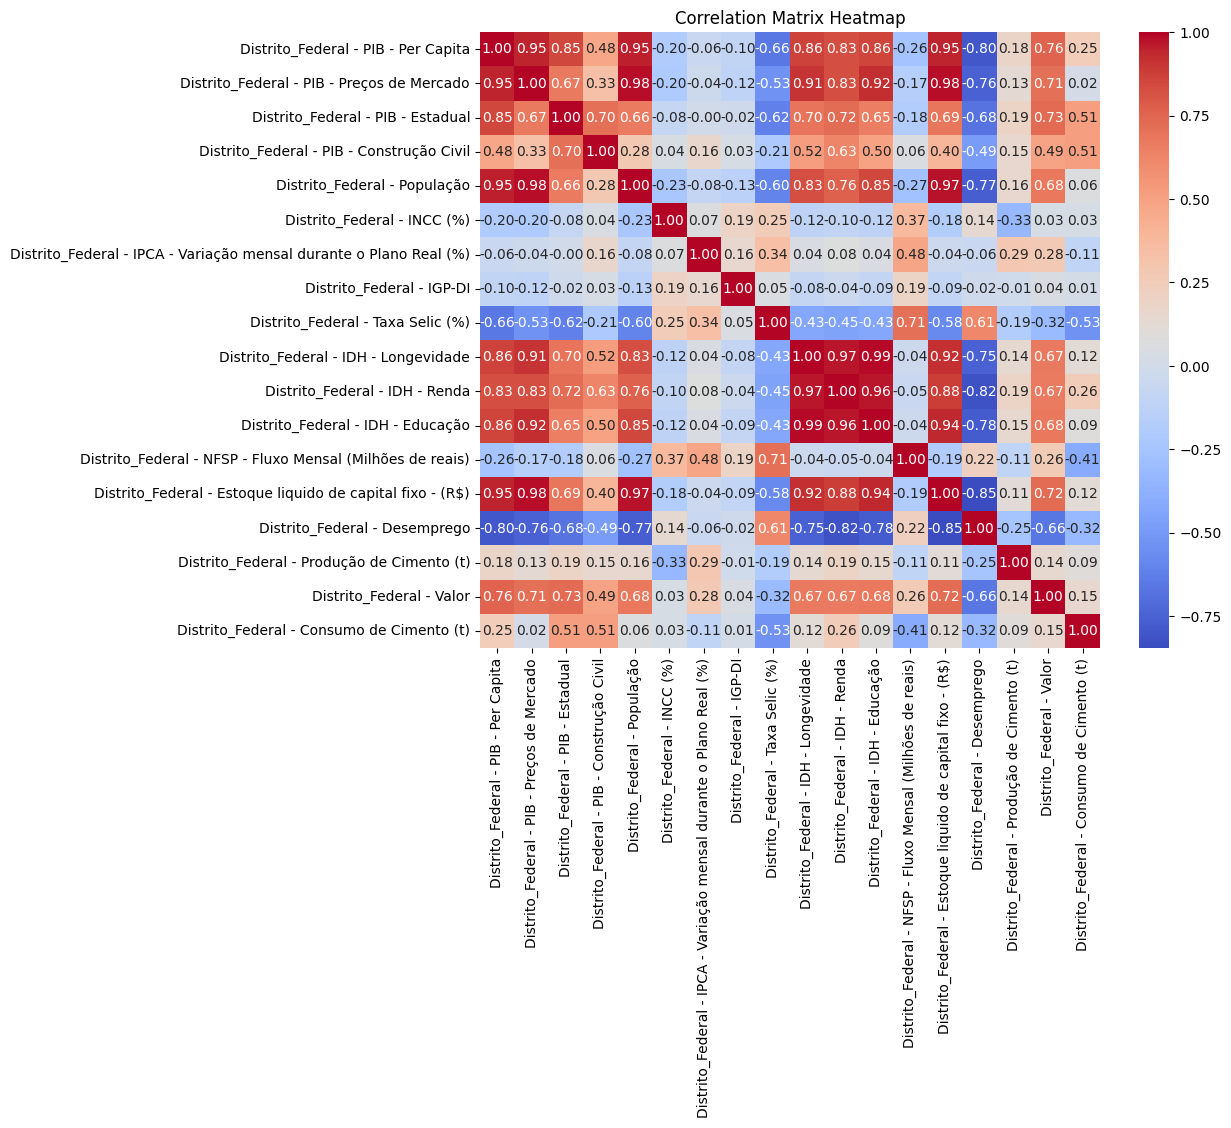

In [9]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [10]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(-1.0)
input_data

,Distrito_Federal - PIB - Per Capita,Distrito_Federal - PIB - Preços de Mercado,Distrito_Federal - PIB - Estadual,Distrito_Federal - PIB - Construção Civil,Distrito_Federal - População,Distrito_Federal - INCC (%),Distrito_Federal - IPCA - Variação mensal durante o Plano Real (%),Distrito_Federal - IGP-DI,Distrito_Federal - Taxa Selic (%),Distrito_Federal - IDH - Longevidade,Distrito_Federal - IDH - Renda,Distrito_Federal - IDH - Educação,Distrito_Federal - NFSP - Fluxo Mensal (Milhões de reais),Distrito_Federal - Estoque liquido de capital fixo - (R$),Distrito_Federal - Desemprego,Distrito_Federal - Produção de Cimento (t),Distrito_Federal - Valor
0,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.998868,4.052332,3.466715,2.303195,-0.925473,-0.92971,-0.919940,3.108599,-1.539424,1.294966,-1.000000,0.586366
1,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.647487,-0.596188,2.630940,2.745235,-0.925473,-0.92971,-0.919940,3.275709,-1.411460,1.294966,-1.000000,0.771320
2,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.425561,0.131839,1.716318,2.879123,-0.925473,-0.92971,-0.919940,3.597074,-1.411460,1.294966,-1.000000,0.771320
3,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.407068,0.706121,1.826703,3.016721,-0.925473,-0.92971,-0.919940,3.738475,-1.411460,1.294966,-0.302152,0.586366
4,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,0.519367,1.167355,-0.144465,3.017322,-0.925473,-0.92971,-0.919940,3.879875,-1.411460,1.294966,-0.431407,0.586366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.376357,1.909322,0.455807,-0.585009,1.698021,-0.590259,-0.966985,-1.264088,-0.729479,1.483292,0.66712,1.477275,-0.374997,1.441346,0.395147,0.193069,0.845302
176,1.376357,1.909322,0.455807,-0.585009,1.698021,-0.479297,-0.881068,-0.412544,-0.941281,1.483292,0.66712,1.477275,-0.439270,1.441346,0.395147,-0.822377,0.715834
177,1.376357,1.909322,0.455807,-0.585009,1.698021,-1.034110,-0.808718,0.186692,-1.140710,1.483292,0.66712,1.477275,-0.503543,1.441346,0.395147,-0.085966,0.734330
178,1.376357,1.909322,0.455807,-0.585009,1.698021,-0.571766,-0.614276,-0.633314,-1.226481,1.483292,0.66712,1.477275,-0.503543,1.441346,0.434009,-0.344983,0.723232


In [11]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Distrito_Federal - PIB - Per Capita,Distrito_Federal - PIB - Preços de Mercado,Distrito_Federal - PIB - Estadual,Distrito_Federal - PIB - Construção Civil,Distrito_Federal - População,Distrito_Federal - INCC (%),Distrito_Federal - IPCA - Variação mensal durante o Plano Real (%),Distrito_Federal - IGP-DI,Distrito_Federal - Taxa Selic (%),Distrito_Federal - IDH - Longevidade,Distrito_Federal - IDH - Renda,Distrito_Federal - IDH - Educação,Distrito_Federal - NFSP - Fluxo Mensal (Milhões de reais),Distrito_Federal - Estoque liquido de capital fixo - (R$),Distrito_Federal - Desemprego,Distrito_Federal - Produção de Cimento (t),Distrito_Federal - Valor
0,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.998868,4.052332,3.466715,2.303195,-0.925473,-0.929710,-0.919940,3.108599,-1.539424,1.294966,-1.000000,0.586366
1,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.647487,-0.596188,2.630940,2.745235,-0.925473,-0.929710,-0.919940,3.275709,-1.411460,1.294966,-1.000000,0.771320
2,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.425561,0.131839,1.716318,2.879123,-0.925473,-0.929710,-0.919940,3.597074,-1.411460,1.294966,-1.000000,0.771320
3,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,1.407068,0.706121,1.826703,3.016721,-0.925473,-0.929710,-0.919940,3.738475,-1.411460,1.294966,-0.302152,0.586366
4,-1.363709,-1.320690,-0.550375,0.699472,-1.641502,0.519367,1.167355,-0.144465,3.017322,-0.925473,-0.929710,-0.919940,3.879875,-1.411460,1.294966,-0.431407,0.586366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.167728,1.502064,0.393595,-0.432922,1.447425,-0.238878,0.629248,-1.406012,0.272188,1.166349,1.128426,1.175106,0.794771,1.416222,-0.770732,-1.000000,0.752825
164,1.167728,1.502064,0.393595,-0.432922,1.447425,-0.608753,0.837256,-0.112926,0.272188,1.166349,1.128426,1.175106,0.730498,1.416222,-0.731869,-1.000000,0.586366
165,1.167728,1.502064,0.393595,-0.432922,1.447425,-0.534778,0.877953,-0.743700,0.272188,1.166349,1.128426,1.175106,0.743353,1.416222,-0.693007,-1.000000,0.793515
166,1.167728,1.502064,0.393595,-0.432922,1.447425,-0.756703,1.000045,-0.586006,0.248413,1.166349,1.128426,1.175106,0.614807,1.416222,-0.693007,-1.000000,0.971071


In [12]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      62.294
1      55.247
2      65.908
3      67.387
4      68.730
        ...  
163    58.854
164    53.940
165    51.514
166    42.635
167    40.371
Name: Distrito_Federal - Consumo de Cimento (t), Length: 168, dtype: float64

In [13]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [14]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [15]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Distrito_Federal - PIB - Per Capita,Distrito_Federal - PIB - Preços de Mercado,Distrito_Federal - PIB - Estadual,Distrito_Federal - PIB - Construção Civil,Distrito_Federal - População,Distrito_Federal - INCC (%),Distrito_Federal - IPCA - Variação mensal durante o Plano Real (%),Distrito_Federal - IGP-DI,Distrito_Federal - Taxa Selic (%),Distrito_Federal - IDH - Longevidade,Distrito_Federal - IDH - Renda,Distrito_Federal - IDH - Educação,Distrito_Federal - NFSP - Fluxo Mensal (Milhões de reais),Distrito_Federal - Estoque liquido de capital fixo - (R$),Distrito_Federal - Desemprego,Distrito_Federal - Produção de Cimento (t),Distrito_Federal - Valor
132,0.656034,0.782971,0.045929,0.791968,0.945041,-0.960135,1.058830,0.297077,-0.755853,0.849407,1.128426,1.175106,-0.285015,0.834026,-1.392534,3.994431,0.641853
133,0.656034,0.782971,0.045929,0.791968,0.945041,0.482379,-1.364912,-0.160234,-0.688658,0.849407,1.128426,1.175106,-0.349288,1.129318,-1.198221,-1.000000,0.697339
134,0.656034,0.782971,0.045929,0.791968,0.945041,-0.534778,-1.052901,0.549386,-0.626634,0.849407,1.128426,1.175106,-0.374997,1.129318,-1.081633,-1.000000,0.641853
135,0.656034,0.782971,0.045929,0.791968,0.945041,-0.627247,-0.627842,1.542855,-0.571481,0.849407,1.128426,1.175106,-0.259306,1.129318,-1.159358,-0.061356,0.549375
136,0.656034,0.782971,0.045929,0.791968,0.945041,0.482379,-0.320352,-0.081387,-0.516512,0.849407,1.128426,1.175106,-0.053632,1.129318,-1.237083,-1.000000,0.586366
137,0.656034,0.782971,0.045929,0.791968,0.945041,2.646150,-0.107822,-1.500628,-0.510405,0.849407,1.128426,1.175106,0.023495,1.129318,-1.314809,-1.000000,0.708436
138,0.656034,0.782971,0.045929,0.791968,0.945041,0.075516,0.082098,-1.784477,-0.510405,0.849407,1.128426,1.175106,-0.002214,1.129318,-1.353671,-1.000000,0.919284
139,0.656034,0.782971,0.045929,0.791968,0.945041,0.241960,0.086620,-1.658322,-0.510405,0.849407,1.128426,1.175106,-0.143614,1.129318,-1.431396,0.222568,0.919284
140,0.656034,0.782971,0.045929,0.791968,0.945041,-0.997122,0.204189,-0.696392,-0.510054,0.849407,1.128426,1.175106,-0.182178,1.129318,-1.509122,-1.000000,0.919284
141,0.656034,0.782971,0.045929,0.791968,0.945041,-0.867666,0.470982,-0.759469,-0.510405,0.849407,1.128426,1.175106,-0.105051,1.129318,-1.586847,-1.000000,0.919284


In [16]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [17]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [18]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [19]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [20]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[390023988, 1082688807, 1201951579, 3462202563, 618337555, 4239480476, 4263445490, 3693186831, 1224496799, 1464225816]


Step: 0 ___________________________________________


2023-11-15 15:03:46.458759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 15:03:46.458939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 15:03:46.459080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 18.223495483398438
winner_seed: 390023988


Step: 1 ___________________________________________
val_loss: 33.196048736572266


Step: 2 ___________________________________________
val_loss: 28.25848388671875


Step: 3 ___________________________________________
val_loss: 20.168909072875977


Step: 4 ___________________________________________
val_loss: 23.284423828125


Step: 5 ___________________________________________
val_loss: 19.087495803833008


Step: 6 ___________________________________________
val_loss: 22.797639846801758


Step: 7 ___________________________________________
val_loss: 54.90766525268555


Step: 8 ___________________________________________
val_loss: 27.62957763671875


Step: 9 ___________________________________________
val_loss: 30.862010955810547


final_seed: 390023988


In [21]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3105829098

Epoch 1/10000
4/4 [==============================] - 2s 126ms/step - loss: 5682.6460 - val_loss: 285.8619
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 607.2523 - val_loss: 1160.1141
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 523.9158 - val_loss: 989.4236
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 499.0189 - val_loss: 568.8812
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 446.0136 - val_loss: 1533.1449
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 467.4890 - val_loss: 47.7317
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 423.0222 - val_loss: 357.2210
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 372.2711 - val_loss: 153.2941
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 223.1412 - val_loss: 49.5615
Epoch 10/10000
4/4 [==============================] - 0s 7ms/step - lo

Epoch 81/10000
4/4 [==============================] - 0s 8ms/step - loss: 29.0199 - val_loss: 26.5059
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.8151 - val_loss: 27.7403
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 37.3591 - val_loss: 29.3093
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.2481 - val_loss: 32.7297
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 45.6874 - val_loss: 49.4105
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.9473 - val_loss: 38.1559
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 24.9723 - val_loss: 26.2283
Epoch 88/10000
4/4 [==============================] - 0s 8ms/step - loss: 23.6886 - val_loss: 26.3983
Epoch 89/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.2301 - val_loss: 39.1467
Epoch 90/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.1920 

4/4 [==============================] - 0s 7ms/step - loss: 9.1062 - val_loss: 34.2469
Epoch 240/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.1564 - val_loss: 30.8075
Epoch 241/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.9554 - val_loss: 49.0981
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.1913 - val_loss: 29.6819
Epoch 243/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2082 - val_loss: 29.8082
Epoch 244/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.5864 - val_loss: 29.5708
Epoch 245/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.4819 - val_loss: 30.2209
Epoch 246/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4616 - val_loss: 29.8230
Epoch 247/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7746 - val_loss: 29.0085
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8941 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 9.4366 - val_loss: 40.3811
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.3610 - val_loss: 41.4581
Epoch 321/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.4011 - val_loss: 31.1939
Epoch 322/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.4849 - val_loss: 31.2405
Epoch 323/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.8452 - val_loss: 29.9980
Epoch 324/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5519 - val_loss: 29.6263
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.7796 - val_loss: 32.5357
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.0861 - val_loss: 31.0870
Epoch 327/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9442 - val_loss: 31.7491
Epoch 328/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.3642 - val_loss: 34.

4/4 [==============================] - 0s 8ms/step - loss: 5.7907 - val_loss: 36.9494
Epoch 480/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0109 - val_loss: 33.3433
Epoch 481/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7021 - val_loss: 32.8622
Epoch 482/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.9010 - val_loss: 33.8636
Epoch 483/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9690 - val_loss: 36.6927
Epoch 484/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1275 - val_loss: 37.7467
Epoch 485/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2069 - val_loss: 33.3857
Epoch 486/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6358 - val_loss: 30.6246
Epoch 487/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.2267 - val_loss: 30.0011
Epoch 488/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8347 - val_loss: 32.6

4/4 [==============================] - 0s 9ms/step - loss: 6.2985 - val_loss: 30.2875
Epoch 640/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5711 - val_loss: 33.3439
Epoch 641/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3660 - val_loss: 30.6227
Epoch 642/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9551 - val_loss: 30.8126
Epoch 643/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5964 - val_loss: 31.7259
Epoch 644/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5883 - val_loss: 31.0716
Epoch 645/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4238 - val_loss: 32.8659
Epoch 646/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6211 - val_loss: 31.1191
Epoch 647/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.5426 - val_loss: 31.2221
Epoch 648/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0896 - val_loss: 32.4

4/4 [==============================] - 0s 7ms/step - loss: 4.6732 - val_loss: 32.5715
Epoch 800/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9333 - val_loss: 30.6883
Epoch 801/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9084 - val_loss: 29.4550
Epoch 802/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2654 - val_loss: 32.2356
Epoch 803/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7985 - val_loss: 29.0668
Epoch 804/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1217 - val_loss: 30.2778
Epoch 805/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9008 - val_loss: 30.8882
Epoch 806/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5158 - val_loss: 29.9448
Epoch 807/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8650 - val_loss: 30.4139
Epoch 808/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5784 - val_loss: 30.6

4/4 [==============================] - 0s 7ms/step - loss: 4.1764 - val_loss: 29.0165
Epoch 960/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1411 - val_loss: 31.0079
Epoch 961/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6312 - val_loss: 30.6222
Epoch 962/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6523 - val_loss: 28.6105
Epoch 963/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9563 - val_loss: 29.6269
Epoch 964/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6681 - val_loss: 28.2359
Epoch 965/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1136 - val_loss: 29.4927
Epoch 966/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5826 - val_loss: 27.7683
Epoch 967/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4812 - val_loss: 32.0362
Epoch 968/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1213 - val_loss: 29.4

4/4 [==============================] - 0s 7ms/step - loss: 3.8095 - val_loss: 29.1015
Epoch 1040/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8520 - val_loss: 28.6199
Epoch 1041/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8489 - val_loss: 27.1035
Epoch 1042/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1730 - val_loss: 31.0866
Epoch 1043/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9896 - val_loss: 29.6698
Epoch 1044/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4853 - val_loss: 29.1788
Epoch 1045/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2333 - val_loss: 28.1964
Epoch 1046/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8646 - val_loss: 28.9607
Epoch 1047/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1121 - val_loss: 26.0211
Epoch 1048/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2576 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 5.0150 - val_loss: 32.0665
Epoch 1198/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7920 - val_loss: 26.8382
Epoch 1199/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2068 - val_loss: 31.4414
Epoch 1200/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0931 - val_loss: 29.3750
Epoch 1201/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7098 - val_loss: 27.1719
Epoch 1202/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8806 - val_loss: 25.5498
Epoch 1203/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7763 - val_loss: 27.5324
Epoch 1204/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5351 - val_loss: 29.2421
Epoch 1205/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5694 - val_loss: 27.9455
Epoch 1206/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0087 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 4.3746 - val_loss: 28.2923
Epoch 1356/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1137 - val_loss: 24.1358
Epoch 1357/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4387 - val_loss: 25.6707
Epoch 1358/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7463 - val_loss: 26.4864
Epoch 1359/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9099 - val_loss: 23.7535
Epoch 1360/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0721 - val_loss: 24.2382
Epoch 1361/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1062 - val_loss: 26.5123
Epoch 1362/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2380 - val_loss: 25.9703
Epoch 1363/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8616 - val_loss: 27.6500
Epoch 1364/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8368 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 3.2004 - val_loss: 23.8402
Epoch 1514/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3383 - val_loss: 23.9973
Epoch 1515/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0757 - val_loss: 25.3239
Epoch 1516/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5159 - val_loss: 28.2176
Epoch 1517/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1048 - val_loss: 24.9197
Epoch 1518/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5127 - val_loss: 24.5655
Epoch 1519/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3598 - val_loss: 27.1594
Epoch 1520/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9995 - val_loss: 27.0473
Epoch 1521/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4513 - val_loss: 27.7262
Epoch 1522/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8450 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 3.7763 - val_loss: 22.1859
Epoch 1672/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5231 - val_loss: 25.3330
Epoch 1673/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7689 - val_loss: 27.2032
Epoch 1674/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5474 - val_loss: 21.9973
Epoch 1675/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3643 - val_loss: 23.1482
Epoch 1676/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2225 - val_loss: 24.3979
Epoch 1677/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0269 - val_loss: 28.0783
Epoch 1678/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6806 - val_loss: 20.7951
Epoch 1679/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0951 - val_loss: 24.1536
Epoch 1680/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3468 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 2.9989 - val_loss: 19.6113
Epoch 1830/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0207 - val_loss: 23.4937
Epoch 1831/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4128 - val_loss: 23.8693
Epoch 1832/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1921 - val_loss: 25.8650
Epoch 1833/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7518 - val_loss: 24.8499
Epoch 1834/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6950 - val_loss: 25.8426
Epoch 1835/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1621 - val_loss: 25.7030
Epoch 1836/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9326 - val_loss: 24.0676
Epoch 1837/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9357 - val_loss: 23.4938
Epoch 1838/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0348 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 2.6093 - val_loss: 24.5393
Epoch 1988/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2793 - val_loss: 21.9227
Epoch 1989/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0763 - val_loss: 22.3780
Epoch 1990/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6751 - val_loss: 24.1405
Epoch 1991/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0170 - val_loss: 18.3472
Epoch 1992/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2518 - val_loss: 21.1172
Epoch 1993/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7625 - val_loss: 23.7937
Epoch 1994/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3320 - val_loss: 23.2751
Epoch 1995/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9136 - val_loss: 24.3587
Epoch 1996/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2645 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 3.5345 - val_loss: 23.8374
Epoch 2146/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7096 - val_loss: 25.9077
Epoch 2147/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6946 - val_loss: 22.0336
Epoch 2148/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0948 - val_loss: 27.7532
Epoch 2149/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7094 - val_loss: 23.5886
Epoch 2150/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0654 - val_loss: 28.6550
Epoch 2151/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.9770 - val_loss: 25.3758
Epoch 2152/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.3786 - val_loss: 21.1440
Epoch 2153/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0117 - val_loss: 24.8133
Epoch 2154/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8655 - val_

4/4 [==============================] - 0s 7ms/step - loss: 2.5592 - val_loss: 22.0301
Epoch 2304/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1718 - val_loss: 23.5594
Epoch 2305/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2917 - val_loss: 21.7981
Epoch 2306/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0777 - val_loss: 25.3772
Epoch 2307/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0161 - val_loss: 21.2388
Epoch 2308/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2174 - val_loss: 23.8689
Epoch 2309/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3771 - val_loss: 23.8493
Epoch 2310/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.5504 - val_loss: 22.9939
Epoch 2311/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7170 - val_loss: 22.2762
Epoch 2312/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7666 - val_l

4/4 [==============================] - 0s 9ms/step - loss: 3.2592 - val_loss: 24.0350
Epoch 2462/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8673 - val_loss: 24.9568
Epoch 2463/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6466 - val_loss: 24.3489
Epoch 2464/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7214 - val_loss: 24.3145
Epoch 2465/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6512 - val_loss: 22.3313
Epoch 2466/10000
4/4 [==============================] - 0s 9ms/step - loss: 3.0451 - val_loss: 21.1657
Epoch 2467/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8829 - val_loss: 28.1312
Epoch 2468/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6353 - val_loss: 22.8775
Epoch 2469/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5235 - val_loss: 22.9225
Epoch 2470/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0689 - val_l

In [22]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [23]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,39.62595,40.128235,41.371742,41.615955,41.798187,40.613266,46.591301,50.655861,49.511742,53.15786,50.745369,50.463165
Target,48.99,44.726,44.491,43.901,55.019,50.942,63.992,64.127,60.822,65.182,51.282,43.554
Error,9.364052,4.597767,3.119259,2.285046,13.220814,10.328735,17.4007,13.471138,11.310257,12.024139,0.536633,6.909164


In [24]:
display(mae)
display(mape)

8.713975

0.15672217

In [25]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [26]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[546.2786]] - Target[637.028]| =  Error: [[90.74939]]; MAPE:[[0.14245746]]


[array([[90.74939]], dtype=float32)]

90.74939

0.14245746